In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from mude_tools import neuralnetplotter
from mude_tools import draw_neural_net
%matplotlib widget

## Introduction

Recall that in the previous notebooks we have applied linear models with basis functions
$$ y(x,\mathbf{w}) = \sum_{j=0}^M w_j \phi_j(x) = \mathbf{w}^T \boldsymbol{\phi} (x).$$

Here $\mathbf{w}$ are the flexible parameters, and $\boldsymbol{\phi}$ the basis functions.

Because a linear model is linear in its parameters $\mathbf{w}$, we could solve for $\bar{\mathbf{w}}$ directly

$$ \bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t},$$

<<<<<<< local
where $\mathbf{\Phi}$ is the collection of basis funcitons evaluated in all data points. The basis function need to be chosen *a priori* for this approach. When the phenomenon to be modeled is complex, relying on pre-defined basis functions might not give sufficient accuracy. We can overcome this issue with a more flexible model is required. Increase flexibility can be achieved by replacing the basis functions with parametric functions. In this notebook we will dive into one variant of this concept, namely neural networks. The underlying problem will stay the same: we are trying to learn a process based on a limited number of noisy observations $\mathcal{D}=\{\mathbf{X}, \mathbf{t}\}$. Following decision theory, we need to minimize the mean squared error loss function
=======
where $\mathbf{\Phi}$ is the collection of basis funcitons evaluated in all data points. The basis functions need to be chosen *a priori* for this approach. When the phenomenon to be modeled is complex, relying on pre-defined basis functions might not give sufficient accuracy. We can overcome this issue with a more flexible model is required. Increase flexibility can be achieved by replacing the basis functions with parametric functions. In this notebook we will dive into one variant of this concept, namely neural networks. The underlying problem will stay the same: we are trying to learn a process based on a limited number of noisy observations $\mathcal{D}=\{\mathbf{X}, \mathbf{t}\}$. Following decision theory, we need to minimize the mean squared error loss function
>>>>>>> remote

$$
E_D =  \frac{1}{N} \sum_{n=1}^N \big(t_n - y(x_n, \mathbf{w}) \big)^2
$$  <!--- \dfrac{1}{2N} -->

where $y(x, \mathbf{w})$ now represents a neural network.

In [2]:
# The true function relating t to x
def f_truth(x, freq=2, **kwargs):

    # Return a sine with a frequency of f
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.7, N=100, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)

    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)

    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)

    # Return both the locations and the observations
    return x, t

## Neural network architecture
A neural network consists of neurons connected by weights, with information flowing from input neurons towards output neurons. The states of the input and output neurons are known during training. There are additional neurons in layers in between the inputs and outputs, forming a so-called hidden layer. Neurons are separated into layers, where all neurons of one layer depend on the neurons of the previous layer.

The state of a neuron is determined by a linear combination of states $z$ from the previous layer with their connecting weights $w$

$$
a^{(l)}_{j} = \sum_{i}^{D} w_{ji}^{(l)} z_{i}^{(l-1)} + w_{j0}^{(l)}
$$

where $w_{j0}^{(l)}$ are the biases, allowing the model to have an offset. Make sure not to confuse this quantity with the model bias. The linear combination of states is followed by a nonlinear transformation with an activation function $h(\cdot)$:

$$
z^{(l)}_{j} = h(a^{(l)}_{j}).
$$

In the plot below, you can see the identity (or linear), sigmoid, hyperbolic tangent (tanh), and rectified linear unit (relu) activation functions.

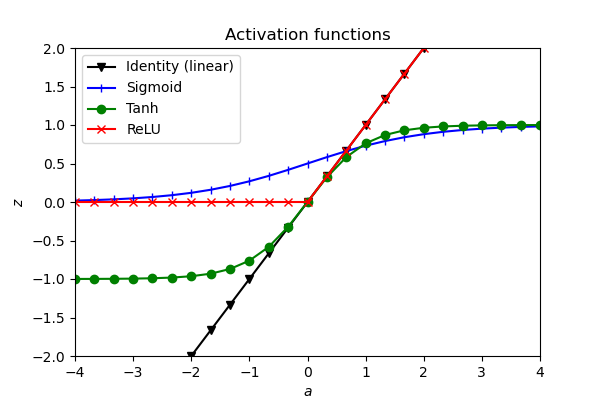

In [3]:
x = np.linspace(-4, 4, 25)

# Compute activation functions
identity = x
sigmoid = [1 / (1 + np.exp(-x)) for x in x]
tanh = np.tanh(x)
relu = [max(0, x) for x in x]

# Plot figure
plt.figure(figsize=(6,4))
plt.plot(x, identity, 'k-v',label='Identity (linear)')
plt.plot(x, sigmoid, 'b-|',label='Sigmoid')
plt.plot(x, tanh, 'g-o',label='Tanh')
plt.plot(x, relu, 'r-x', label='ReLU') # c='red', linestyle=(0, (20, 30)),label='relu')
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.xlabel('$a$')
plt.ylabel('$z$')
plt.title('Activation functions')
plt.legend()
plt.show()


The number of layers in a neural network commonly refers to the number of hidden layers. The formulation of a two-layer neural network is thus:

$$
y(x, \mathbf{w}) = h^{(out)} \left( \sum_{k=1}^{K} w_{k}^{(3)} h^{(2)} \bigg( \sum_{j=1}^{J} w_{kj}^{(2)} h^{(1)} \Big( \sum_{i=1}^{I} w_{ji}^{(2)} x_i + w_{j0}^{(1)} \Big) + w_{k0}^{(2)} \bigg) + w_{0}^{(3)} \right)
$$

With the nonlinear activation functions, the model is evidently no longer linear in the weights and, in general, no closed-form solution can be found. Instead, some sort of gradient-based optimization scheme, as discussed in the previous notebook in the form of SGD, is required calibrate the weights.

When your dataset contains multiple inputs or outputs, this model can easily be extended by including multiple neurons in the input or output layer, the other procedures stay the same. Generally, the activation function of the outputs $h^{(out)}$ is linear, the activations in hidden layers are of a nonlinear type.

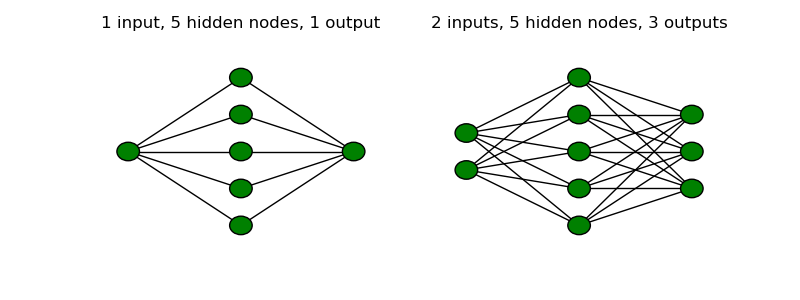

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
draw_neural_net(ax[0], .1, .9, .1, .9, [1, 5, 1])
draw_neural_net(ax[1], .1, .9, .1, .9, [2, 5, 3])
ax[0].set_title('1 input, 5 hidden nodes, 1 output')
ax[1].set_title('2 inputs, 5 hidden nodes, 3 outputs')
[axs.axis('off') for axs in ax]
plt.show()

# Model flexibility

The neutral network's flexibility can be adapted by varying the number of neurons per hidden layer, or by adding more hidden layers. Both options lead to an increase number of parameters $\mathbf{w}$. When a neural network has too little parameters, it generally puts us at risk at underfitting the data, whereas having too many parameters quickly leads to overfitting. The number of layers and neurons per layer are hyperparameters, which need to be calibrated. They are typically determined by fitting multiple models on hold-out data.

In the following interactive plot you can study the influence of the number of neurons per layer on the model's prediciton. The number of hidden layers is fixed at two. You to to click the re-run button to retrain the model after varying the parameter. Be aware that the required computations take a few seconds.

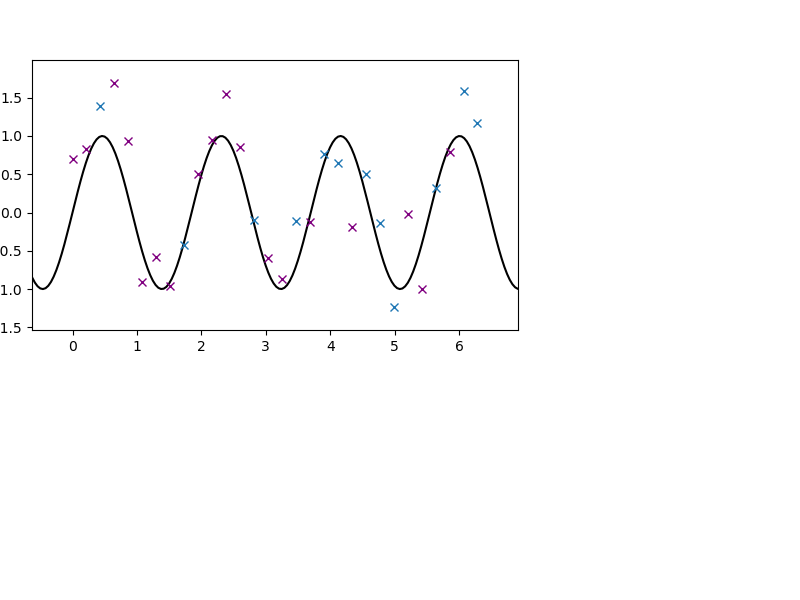

In [5]:
# Define the prediction locations
# (note that these are different from the locations where we observed our data)
x_pred = np.linspace(-1, 2*np.pi+1, 200)

xscaler = StandardScaler()
xscaler.fit(f_data()[0][:,None])

# Function that creates a NN
def create_NN(**kwargs):
    return MLPRegressor(solver='sgd', hidden_layer_sizes=(kwargs['neurons'], kwargs['neurons']),
                        activation=kwargs['activation'], batch_size=kwargs['batch_size'])


# Function that trains a given NN for a given number of epochs
def NN_train(x, t, **kwargs):

    # Get the network from the kwargs
    network = kwargs.get('network')
    
    # Convert the training data to a column vector and normalize it
    X = x.reshape(-1, 1)
    X = xscaler.transform(X)

    # Get the number of epochs per block
    epochs_per_block = int(round(kwargs['epochs'] / kwargs['epoch_blocks'], 0))

    # Run a number of epochs
    for i in range(epochs_per_block):
        network.partial_fit(X, t)

    return network, network.loss_curve_


# Function that returns predictions from a given NN model
def NN_pred(x, t, x_pred, **kwargs):

    # Get the network from the kwargs
    network = kwargs.get('network')
    return_network = kwargs.get('return_network', False)

    if network is None:
        network = create_NN(**kwargs)
        kwargs['network'] = network
        retrain = True
    else:
        retrain = kwargs.get('train_network', True)

    # Convert the prediction data to a column vector and normalize it
    X_pred = x_pred.reshape(-1, 1)
    X_pred = xscaler.transform(X_pred)

    if retrain:
        network, train_loss = NN_train(x, t, **kwargs)

    # Make a prediction at the locations given by x_pred
    y = network.predict(X_pred)

    if return_network:
        return y, network, train_loss
    else:
        return y

plot1 = neuralnetplotter(f_data, f_truth, NN_pred, x_pred, val_pct=60) # title=r'Run cell above plot before using!')
plot1.add_sliders('neurons', valmax=20, valinit=3)
plot1.add_buttons('truth', 'seed', 'rerun')
# plot1.add_radiobuttons('activation')
plot1.show()


In [11]:
plot1.toggle_truth(0)

As you might have noticed, using the default setting of three neurons per layer was not enough for the network to learn the underlying trend in the data. Which number of neurons per layer gave you a visibly good fit?<!-- Does the validation error support your feeling?-->

## Early stopping

Choosing a high number of neurons increases the number of parameters and, therefore, slows down training. In addition, it can make the model too flexible and prone to overfitting. It is therefore good practive to always monitor the predictive capability of a NN on a validation set. First, run the model below, then, select the model you think best fits the data by pulling the corresponding slider. At which epoch do you find the best model?

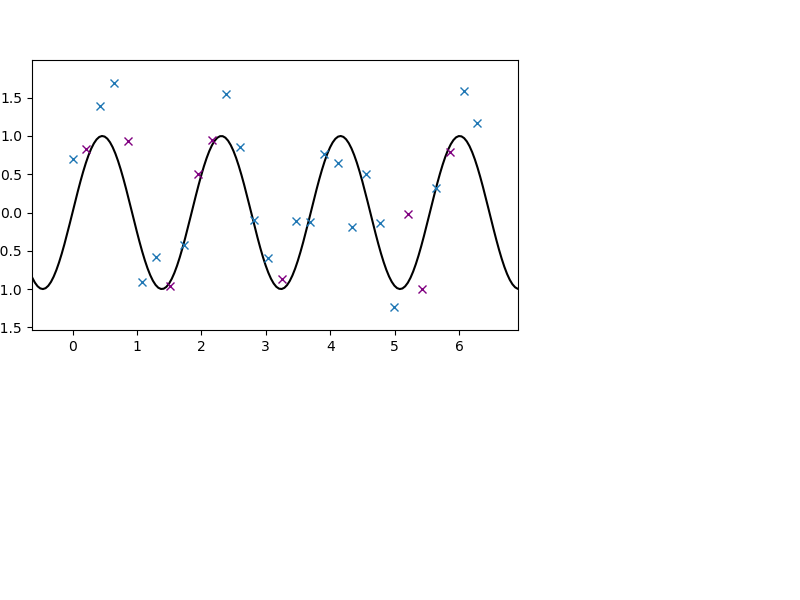

In [7]:
plot2 = neuralnetplotter(f_data, f_truth, NN_pred, x_pred)
plot2.defaults['neurons']['valinit'] = 20
plot2.defaults['N']['valinit'] = 40
plot2.defaults['val_pct']['valinit'] = 60
plot2.defaults['batch_size']['valinit'] = 2
plot2.defaults['epochs']['valinit'] = 12000
plot2.seed = 4
plot2.add_sliders('cur_model')
plot2.add_buttons('truth', 'rerun')
plot2.show()

It is possible to train a neural network for a long time, and selecting one with a low validation error. An alternative, known as early stopping, uses the indication that the validation loss increases for a number of epochs as a stopping sign to halt training.

Our strategy to train the network for a considerable amount of time and the select the one with the lowest validation error is valid, but not particularily efficient. An alternative known as early stopping constantly checks the validation error, and haults the training phase once an increase in said error (or its moving average) is detected. 

In a finite data setting, an increasing validation error does not give us certainty that we are staring to overfit our model, but it is a good indicator for this event. In our case, we know the process and have access to infinite data. For demonstration purposes, the true error of our model is computed alongside the validation error. If we draw a validation set that poorly represents our target, it can gives us confidence in our predictions that are very far off.

<!--The true error is computed since the underlying model is known here. The validation error aims to approximate this true error, and in practice should be used to find the best model. The more data available, the more the training loss approximates the true loss. In the case plotted above, the minimum of the validation loss coincides with the minimum of the true loss.-->

## Manual model selection

In the previous notebook we used L<sub>2</sub>-regularization to control the model complexity. The application of this technique to neural networks is straightforward, and will therefore not be demonstrated here. Instead, we will focus on the impact of the number of trainable parameters and the number of samples on overfitting. The ability to display our models at different stages of the training phase will help us to find and inspect particularily good or bad models.

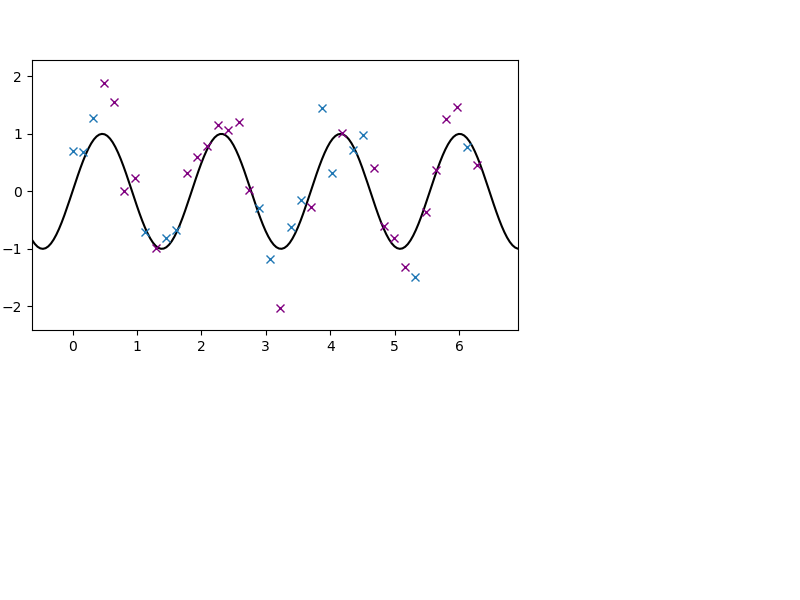

In [8]:
plot3 = neuralnetplotter(f_data, f_truth, NN_pred, x_pred, nnlinewidth=0.25)
plot3.add_sliders('freq', 'neurons', 'N', 'cur_model', 'val_pct')
plot3.add_buttons('truth', 'seed', 'rerun')
plot3.add_radiobuttons('activation')
plot3.show()

Train a number of different neural networks with varying hyperparameter settings, and try to understand the influence of all the the parameters on the resulting model. Try to answer the following questions:

* Is the model with the lowest validation error always the model that, in your eyes, gives the best fit visually?
* In practical situations when dealing with multiple inputs and outputs, it is often difficult to visualize the predictions for the whole domain. Can you detect when a model is underfit based only on the taining and validation loss?
* For a well-trained flexible model with a large training size (N) the errors usually converge to a specific value. What is this value and why does this happen? What happens when the training error is below this value when using a small training size (N)?

For a 2D demonstration that includes classification you can check out the [tensorflow playground][1].

[1]: https://playground.tensorflow.org/

<<<<<<< local
# Wrap-up
=======
## Wrap-up
>>>>>>> remote

In these lectures you have seen a non-parametric model, namely k-nearest neighbours, and have learned about the bias-variance trade-off. Linear regression was shown as a parametric model that is linear in its parameters and has a closed form solution. Ridge regression has been introduced to prevent overfitting. Stochastic gradient descent has been shown as a way to train a model in an iterative fashion. In this final notebook, we explored a model with a nonlinear dependence on its parameters. You now understand the underlying principles of a broad set machine learning techniques, and know how to distinguish naive curve fitting from extracting (or learning) the relevant trends and pattern in the data.